# Applied Statistical Learning in Python

## Exercise Solutions: Leukemia Diagnosis

You are given a dataset on 72 tissue samples taken from leukemia patients. The first 107 columns are gene expression measurements for genes known to be relevant to leukemia based on current knowledge. The last column is a label with 0 indicating that the patient had Acute Lymphoblastic Leukemia (ALL), while 1 indicating Acute Myeloid Leukemia (AML). Your task is to build a classification model to predict whether patients have ALL or AML based on their genetic expression values. Your model will be used as a diagnostic tool for new patients with leukemia.

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Q1. Read in the dataset `leukemia.csv`. Print the first 5 rows. Check its dimensions.

In [5]:
# load and inspect the data
data = pd.read_csv('leukemia.csv')
data.head()

,M84371_rna1_s_at,J03779_at,X82240_rna1_at,U22376_cds2_s_at,U79262_at,M27396_s_at,J04948_at,M19508_xpt3_s_at,M22324_at,M23197_at,...,D88270_at,X15414_at,X63527_at,X67951_at,L13278_at,L14848_s_at,U46006_s_at,U49957_s_at,X01677_f_at,label
0,1477,6109,2302,2037,936,-7,736,1182,729,168,...,2006,1076,20415,4907,67,144,214,-24,12869,0
1,2758,3545,-111,1497,636,40,323,493,-203,244,...,1803,992,25795,3255,216,424,325,19,17954,0
2,721,3047,116,2105,681,135,616,1002,42,154,...,3110,1443,22761,2871,100,-12,48,1,17102,0
3,779,2126,212,2805,672,56,416,811,424,287,...,1924,512,14571,601,176,-27,33,-35,17048,0
4,2338,4498,18727,6996,1087,93,363,777,289,222,...,10157,3395,21771,7201,461,210,755,-39,12692,0


In [6]:
data.shape

(72, 108)

## Q2. Split the data into training (67%) and testing (33%) sets. Check their dimensions.

In [7]:
# prepare predictor and response arrays from data
x = data.values[:, 0:107]
y = data.values[:, 107]
print ('x:', x.shape)
print ('y:', y.shape)

x: (72, 107)
y: (72,)


In [8]:
# split the data into training (67%) and testing (33%) sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=123)

# sanity check
print ('Train set: ', x_train.shape)
print ('Test set: ', x_test.shape)
print ('Train ALL: {}, Train AML: {}'.format(len(y_train[y_train==0]), len(y_train[y_train==1])))
print ('Test ALL: {}, Test AML: {}'.format(len(y_test[y_test==0]), len(y_test[y_test==1])))

Train set:  (48, 107)
Test set:  (24, 107)
Train ALL: 34, Train AML: 14
Test ALL: 13, Test AML: 11


## Q3. Train 3 separate models using logistic regression, random forest and support vector machines. Compare their overall test accuracies, as well as test accuracies for predicting ALL and AML.

In [9]:
# function for scoring the overall and by-class test accuracy of a given model
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['Overall test accuracy', 'Test accuracy on ALL', 'Test accuracy on AML'])

In [10]:
# logistic regression
lr = LogisticRegression(class_weight='balanced')
lr.fit(x_train, y_train)
lr_scores = score(lr, x_test, y_test)

# random forest
rf = RandomForestClassifier(class_weight='balanced', n_estimators=30)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)

# svm
svm = SVC(class_weight='balanced')
svm.fit(x_train, y_train)
svm_scores = score(svm, x_test, y_test)

# present scores in a dataframe
score_df = pd.DataFrame({'Logistic Reg': lr_scores, 'Random Forest': rf_scores, 'SVM': svm_scores})
score_df

,Logistic Reg,Random Forest,SVM
Overall test accuracy,0.875000,0.958333,0.541667
Test accuracy on ALL,0.923077,1.000000,1.000000
Test accuracy on AML,0.818182,0.909091,0.000000


## Q4. Use 3-fold cross-validation to find the best number and maximum depth of trees for the random forest model. Use 3-fold cross-validation to find the best kernel and regularization parameter `C` for the SVM model.

In [11]:
# tune random forest
parameters = {'n_estimators': [10, 30, 50], 'max_depth': range(1, 10)}
rf = RandomForestClassifier(class_weight='balanced')
rf_tuned = GridSearchCV(rf, parameters, cv=3)
rf_tuned.fit(x_train, y_train)
print ('Overall accuracy for random forest model with {}: {}'.format(rf_tuned.best_params_, score(rf_tuned, x_test, y_test)[0]))

Overall accuracy for random forest model with {'max_depth': 2, 'n_estimators': 30}: 1.0


In [12]:
# tune svm
parameters = {'kernel': ['linear', 'rbf'], 'C': [0.001, 0.01, 0.1, 1, 10]}
svm = SVC(class_weight='balanced')
svm_tuned = GridSearchCV(svm, parameters, cv=3)
svm_tuned.fit(x_train, y_train)
print ('Overall accuracy for SVM model with {}: {}'.format(svm_tuned.best_params_, score(svm_tuned, x_test, y_test)[0]))

Overall accuracy for SVM model with {'C': 0.001, 'kernel': 'linear'}: 0.875


## Q5. Plot Receiver Operating Characteristic (ROC) curves for the 3 models in a graph and compare their areas under the curve (AUC). Use parameters tuned from above.

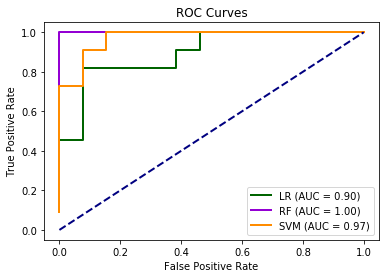

In [13]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# logistic regression
lr = LogisticRegression(class_weight='balanced')
lr_probas = lr.fit(x_train, y_train).predict_proba(x_test)
fpr["LR"], tpr["LR"], _ = roc_curve(y_test, lr_probas[:, 1])
roc_auc["LR"] = auc(fpr["LR"], tpr["LR"])

# random forest
rf = RandomForestClassifier(class_weight='balanced', n_estimators=30, max_depth=2)
rf_probas = rf.fit(x_train, y_train).predict_proba(x_test)
fpr["RF"], tpr["RF"], _ = roc_curve(y_test, rf_probas[:, 1])
roc_auc["RF"] = auc(fpr["RF"], tpr["RF"])

# svm
svm = SVC(class_weight='balanced', kernel='linear', C=0.001)
svm_probas = svm.fit(x_train, y_train).decision_function(x_test)
fpr["SVM"], tpr["SVM"], _ = roc_curve(y_test, svm_probas)
roc_auc["SVM"] = auc(fpr["SVM"], tpr["SVM"])

# plot
plt.figure()
plt.plot(fpr["LR"], tpr["LR"], color='darkgreen', lw=2, label='LR (AUC = %0.2f)' % roc_auc["LR"])
plt.plot(fpr["RF"], tpr["RF"], color='darkviolet', lw=2, label='RF (AUC = %0.2f)' % roc_auc["RF"])
plt.plot(fpr["SVM"], tpr["SVM"], color='darkorange', lw=2, label='SVM (AUC = %0.2f)' % roc_auc["SVM"])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

## Q6. Choose which model you would use for the diagnostic tool and explain your choice.

<i>Random forest model. It achieved the highest area under the ROC curve.</i>

## Q7. Visualize the top 10 most predictive genes and their relative importance in the random forest model.

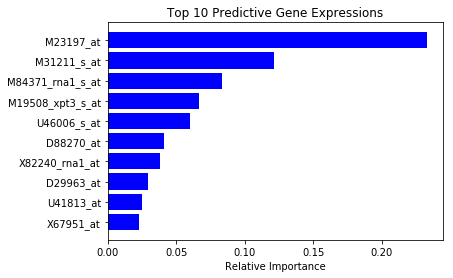

In [15]:
# obtain feature importance list and sort
importances = rf.feature_importances_
indices = np.argsort(importances)
top10_indices = indices[-10:]

# extract gene names
features = data.columns

# plot
plt.title('Top 10 Predictive Gene Expressions')
plt.barh(range(len(top10_indices)), importances[top10_indices], color='blue', align='center')
plt.yticks(range(len(top10_indices)), features[top10_indices])
plt.xlabel('Relative Importance')
plt.show()